In [61]:
# python=3.8
# conda env name : gender_pred_env

# Packges

In [62]:
import joblib
import numpy as np
import pandas as pd
import pickle
import optuna
import warnings
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, Flatten, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Adjusting warnings
warnings.filterwarnings('ignore')

In [63]:
# Load Data
df = pd.read_pickle('data/dataset_after_preporcessing.pkl')
df.head()

,name,sex,name_length,last_letter,first_letter
0,ابتسام,0,6,م,ا
1,ابتهاج,0,6,ج,ا
2,ابتهال,0,6,ل,ا
3,اجتهاد,0,6,د,ا
4,ازدهار,0,6,ر,ا


In [64]:
max_name_length = max(df['name'].apply(len))
unique_chars = set(''.join(df['name']))  
vocab_size = len(unique_chars) + 1  

with open('saved_models/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

sequences = tokenizer.texts_to_sequences(df['name'])
padded_sequences = pad_sequences(sequences, maxlen=max_name_length)

In [65]:
first_letter = df['name'].apply(lambda x: x[0])
last_letter = df['name'].apply(lambda x: x[-1])

first_letter_encoded = np.array([ord(char) for char in first_letter])
last_letter_encoded = np.array([ord(char) for char in last_letter])

max_unicode_value_first = np.max(first_letter_encoded)
max_unicode_value_last = np.max(last_letter_encoded)
max_unicode_value = max(max_unicode_value_first, max_unicode_value_last)

In [66]:
# Load the scaler models
scaler_first = joblib.load('saved_models/scaler_models/scaler_first_letter.pkl')
scaler_last = joblib.load('saved_models/scaler_models/scaler_last_letter.pkl')

# Transform the new data using the loaded scalers
first_letter_encoded_scaled = scaler_first.transform(first_letter_encoded.reshape(-1, 1))
last_letter_encoded_scaled = scaler_last.transform(last_letter_encoded.reshape(-1, 1))

In [67]:
y = df['sex'].values
name_length = df['name_length'].values
X = list(zip(padded_sequences, first_letter_encoded_scaled, last_letter_encoded_scaled, name_length))

# Define the size for the test and validation sets as percentages
test_size_percentage = 0.1
validation_size_percentage = 0.1

# Calculate the actual sizes for the test and validation sets
total_size = test_size_percentage + validation_size_percentage
test_size_actual = test_size_percentage / total_size
validation_size_actual = validation_size_percentage / total_size

train_size_percentage = 1 - total_size

# First split: Separate out the training data and the remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=total_size, random_state=11)

# Second split: Separate the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=test_size_actual, random_state=11)

# Print the number of samples in the training, validation, and test sets
print(f"Training set size: {len(X_train)}, Labels: {len(y_train)}")
print(f"Validation set size: {len(X_val)}, Labels: {len(y_val)}")
print(f"Test set size: {len(X_test)}, Labels: {len(y_test)}")

# Unpack the training data into separate arrays for each input
name_train, first_letter_train, last_letter_train, length_train = zip(*X_train)
name_val, first_letter_val, last_letter_val, length_val = zip(*X_val)
name_test, first_letter_test, last_letter_test, length_test = zip(*X_test)

# Convert tuples to numpy arrays
name_train = np.array(name_train)
first_letter_train = np.array(first_letter_train)
last_letter_train = np.array(last_letter_train)
length_train = np.array(length_train)

name_val = np.array(name_val)
first_letter_val = np.array(first_letter_val)
last_letter_val = np.array(last_letter_val)
length_val = np.array(length_val)

name_test = np.array(name_test)
first_letter_test = np.array(first_letter_test)
last_letter_test = np.array(last_letter_test)
length_test = np.array(length_test)

# Reshape the length arrays to have two dimensions
length_train = length_train.reshape(-1, 1)
length_val = length_val.reshape(-1, 1)
length_test = length_test.reshape(-1, 1)

# Concatenate the features
X_train = np.concatenate([name_train, first_letter_train, last_letter_train, length_train], axis=1)
X_val = np.concatenate([name_val, first_letter_val, last_letter_val, length_val], axis=1)
X_test = np.concatenate([name_test, first_letter_test, last_letter_test, length_test], axis=1)
total_features_shape = X_train.shape[1]

Training set size: 6922, Labels: 6922
Validation set size: 865, Labels: 865
Test set size: 866, Labels: 866


In [68]:


def lstm_objective(trial):
    # Hyperparameters to be tuned by Optuna for BiLSTM
    embedding_dim = trial.suggest_categorical('embedding_dim', [32, 64, 128, 256,512])
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128, 256])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    l2_lambda = trial.suggest_loguniform('l2_reg', 1e-6, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    epochs = trial.suggest_int('epochs', 5, 50)
    patience_for_early_stopping = trial.suggest_int('patience_for_early_stopping', 1, 10)

    # Define the model architecture using the hyperparameters
    model = Sequential()

    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=total_features_shape))

    model.add(Bidirectional(LSTM(lstm_units,return_sequences=True,kernel_regularizer=l2(l2_lambda))))

    model.add(Dropout(dropout_rate))

    model.add(Bidirectional(LSTM(lstm_units//2,kernel_regularizer=l2(l2_lambda))))

    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Use early stopping as a callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience_for_early_stopping)
    
    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # The objective we want to minimize (validation loss in this case)
    val_loss = np.min(history.history['val_loss'])
    
    # Optionally, you can return additional information to be used later
    trial.set_user_attr('stopped_epoch', len(history.history['loss']))

    return val_loss

In [69]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(lstm_objective, n_trials=5)

[I 2024-01-23 14:33:52,373] A new study created in memory with name: no-name-514cf9a7-9226-4a99-bdd8-326b504276dd


In [ ]:
# Best hyperparameters
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
best_lstm_params = study.best_trial.params

In [ ]:
def get_model_summary(model):
    """
    Generates the summary of the given Keras model and returns it as a string.

    Args:
    model (keras.Model): The Keras model to summarize.

    Returns:
    str: The summary of the model.
    """
    model_summary_list = []
    model.summary(print_fn=lambda x: model_summary_list.append(x))
    return '\n'.join(model_summary_list)


In [ ]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Gender Prediction Models Tracking")

<Experiment: artifact_location='mlflow-artifacts:/461486716067717122', creation_time=1705996741401, experiment_id='461486716067717122', last_update_time=1705996741401, lifecycle_stage='active', name='Gender Prediction Models Tracking', tags={}>

In [ ]:
# MLflow tracking
with mlflow.start_run():
    # Log model parameters
    
    mlflow.log_params({
        "max_name_length": max_name_length,
        "vocab_size": vocab_size,
        "train_size_percentage": train_size_percentage,
        "test_size_percentage": test_size_percentage,
        "validation_size_percentage": validation_size_percentage
    })
    
    mlflow.log_params(best_lstm_params)

    # Define the model architecture using the hyperparameters
    model = Sequential()

    model.add(Embedding(input_dim=vocab_size, output_dim=best_lstm_params['embedding_dim'], input_length=total_features_shape))

    model.add(Bidirectional(LSTM(best_lstm_params['lstm_units'],return_sequences=True,kernel_regularizer=l2(best_lstm_params['l2_reg']))))

    model.add(Dropout(best_lstm_params['dropout_rate']))

    model.add(Bidirectional(LSTM(best_lstm_params['lstm_units']//2,kernel_regularizer=l2(best_lstm_params['l2_reg']))))

    model.add(Dropout(best_lstm_params['dropout_rate']))

    model.add(Dense(1, activation='sigmoid'))

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=best_lstm_params['patience_for_early_stopping'])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=best_lstm_params['epochs'],
        batch_size=best_lstm_params['batch_size'],
        callbacks=[early_stopping],
        verbose=1
    )

    # Log training history
    for epoch in range(len(history.history['accuracy'])):
        mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    val_loss, val_accuracy = model.evaluate(X_val, y_val)

    # Predictions and additional metrics
    y_pred = model.predict(X_test)
    y_pred_classes = np.where(y_pred > 0.5, 1, 0).reshape(-1)
    f1 = f1_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # Calculate AUC (Area Under the ROC Curve)
    roc_auc = auc(fpr, tpr)

    # Confusion matrix calculation
    cm = confusion_matrix(y_test, y_pred_classes)
    cm_dict = {f"{i}-{j}": cm[i, j] for i in range(cm.shape[0]) for j in range(cm.shape[1])}

    # Log additional metrics
    mlflow.log_metrics({
    "test_f1": f1,
    "test_precision": precision,
    "test_recall": recall,
    "test_roc_auc": roc_auc,
    "test_loss": test_loss, 
    "test_accuracy": test_accuracy,
    "train_accuracy":train_accuracy,
    "train_loss":train_loss,
    "val_loss":val_loss,
    "val_accuracy":val_accuracy
    })

    # Infer the signature using the combined data and predictions
    signature = infer_signature(X_test, y_pred)

    mlflow.keras.log_model(model, "model", signature=signature)

    # Set additional tags
    mlflow.set_tags({
        "Description": "Character-Level BiLSTM",
        "Encoding": "Character-Level for name | other featuers Coverting them to thier ASCI value then norm",
        "Features": ', '.join(df.columns.tolist()),
        'Number of Features':len(df.columns.tolist()),
        "Model Type": "BiLSTM",
        "model_architecture": get_model_summary(model),
        'confusion_matrix':list(cm_dict.values())
    })
# End MLflow run

Epoch 1/100
217/217 [==============================] - 44s 173ms/step - loss: 0.5273 - accuracy: 0.7845 - val_loss: 0.4262 - val_accuracy: 0.8324
Epoch 2/100
217/217 [==============================] - 40s 186ms/step - loss: 0.4400 - accuracy: 0.8135 - val_loss: 0.4080 - val_accuracy: 0.8347
Epoch 3/100
217/217 [==============================] - 47s 217ms/step - loss: 0.4179 - accuracy: 0.8259 - val_loss: 0.3798 - val_accuracy: 0.8405
Epoch 4/100
217/217 [==============================] - 45s 208ms/step - loss: 0.4064 - accuracy: 0.8285 - val_loss: 0.3682 - val_accuracy: 0.8486
Epoch 5/100
217/217 [==============================] - 46s 211ms/step - loss: 0.3987 - accuracy: 0.8304 - val_loss: 0.3732 - val_accuracy: 0.8613
Epoch 6/100
217/217 [==============================] - 45s 205ms/step - loss: 0.3897 - accuracy: 0.8385 - val_loss: 0.3936 - val_accuracy: 0.8324
Epoch 7/100
217/217 [==============================] - 44s 202ms/step - loss: 0.3855 - accuracy: 0.8362 - val_loss: 0.3617 -

INFO:tensorflow:Assets written to: C:\Users\FARISA~1\AppData\Local\Temp\tmpz_njl3ys\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\FARISA~1\AppData\Local\Temp\tmpz_njl3ys\model\data\model\assets


In [ ]:
print()
print('-----------------------------------------------------------')
print(f"Train Accuracy: {round(train_accuracy, 3)}")
print(f"Val Accuracy: {round(val_accuracy, 3)}")
print(f"Test Accuracy: {round(test_accuracy, 3)}")
print("\n---Metrics---\n")
print(f"F1 Score: {round(f1, 3)}")
print(f"Precision: {round(precision, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"ROC AUC: {round(roc_auc, 3)}")
print("\n---Loss---\n")
print(f"Train Loss: {round(train_loss, 3)}")
print(f"Val Loss: {round(val_loss, 3)}")
print(f"Test Loss: {round(test_loss, 3)}")
print('-----------------------------------------------------------')


-----------------------------------------------------------
Test Accuracy: 0.846
Train Accuracy: 0.888

---Metrics---

F1 Score: 0.898
Precision: 0.879
Recall: 0.917
ROC AUC: 0.904

---Loss---

Test Loss: 0.37
Train Loss: 0.284
-----------------------------------------------------------


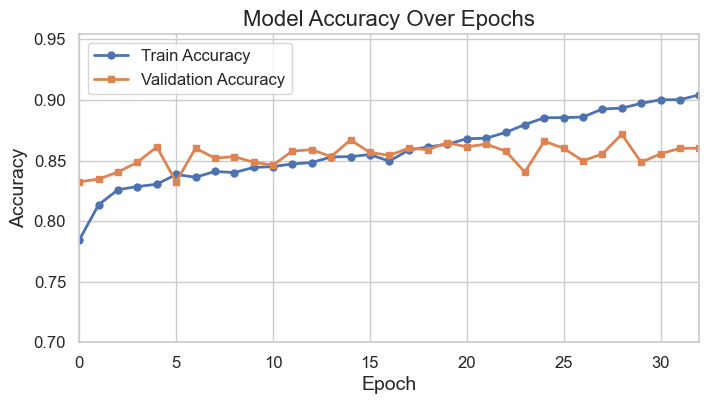

In [ ]:
# Apply the seaborn style to make plots nicer
sns.set(style="whitegrid")

# Create the figure with a specific size
plt.figure(figsize=(8, 4))

# Accuracy plot
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o', markersize=5)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=5)

# Title and labels
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Legend
plt.legend(loc='upper left', fontsize=12)

# Set limits and ticks for readability
plt.xlim(0, len(history.history['accuracy']) - 1)
plt.ylim(0.7, max(max(history.history['accuracy']), max(history.history['val_accuracy'])) + 0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

[150, 80, 53, 583]

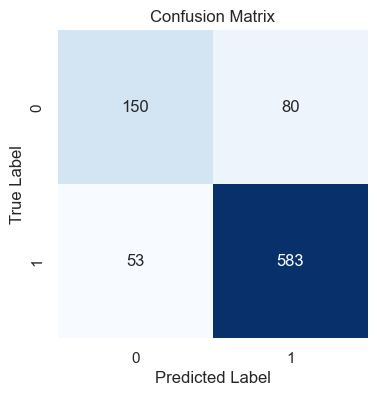

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label');
list(cm_dict.values())

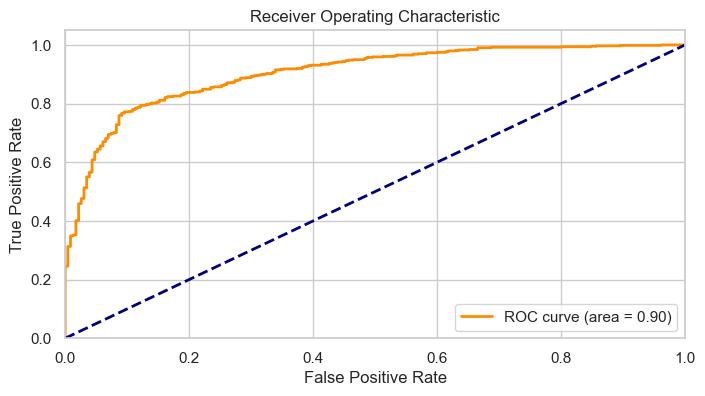

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right');

In [ ]:
model.save(f"saved_models/BiLSTM_Acc_{round(test_accuracy, 3)}_F1_{round(f1, 3)}_Roc_{round(roc_auc, 3)}.h5")